In [1]:

import glob
import PIL
from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


ModuleNotFoundError: No module named 'seaborn'

In [2]:
!pip install seaborn

     |████████████████████████████████| 225kB 767kB/s eta 0:00:01
     |████████████████████████████████| 10.0MB 2.4MB/s eta 0:00:01
     |████████████████████████████████| 512kB 10.4MB/s eta 0:00:01


In [3]:
import seaborn as sns
sns.set()

In [4]:
bg_images = [f for f in glob.glob('background/bg/*.*')]

In [5]:
img = Image.open(bg_images[0])

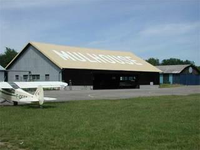

In [11]:
img.thumbnail((200, 200), Image.ANTIALIAS)
img

In [16]:
def crop_center(pil_img):
    img_width, img_height = pil_img.size
    crop_dim = img_width if img_width < img_height else img_height
    crop_width = crop_height = crop_dim
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

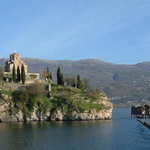

In [17]:
crop_center(img)

In [18]:
size = (200, 200)
for idx, bg_file in enumerate(bg_images):
    img = Image.open(bg_file)
    img = crop_center(img)
    img.thumbnail(size, Image.ANTIALIAS)
    img = img.convert('RGB')
    img.save(f'bgformat/bg/{idx:03d}.jpg', optimize=True, quality=60)

In [19]:
fg_images = [f for f in glob.glob('foreground/fg/*.*')]

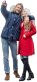

In [21]:
img = Image.open(fg_images[0])
img.thumbnail((200, 200), Image.ANTIALIAS)
img

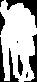

In [23]:
img = cv2.imread(fg_images[0], cv2.IMREAD_UNCHANGED)
ret, mask = cv2.threshold(img[:, :, 3], 0, 255, cv2.THRESH_BINARY)
img = Image.fromarray(mask)
img.thumbnail((200, 200), Image.ANTIALIAS)
img

In [24]:

for idx, fg_file in enumerate(fg_images):
    # original image
    o_img = cv2.imread(fg_file, cv2.IMREAD_UNCHANGED)
    img = cv2.imread(fg_file, cv2.IMREAD_UNCHANGED)
    
    _, mask = cv2.threshold(img[:, :, 3], 0, 255, cv2.THRESH_BINARY)

    mask_height, mask_width = mask.shape

    max_size = np.random.randint(low=80, high=110, size=1)[0]

    if mask_width > mask_height:
        reduce_by = max_size / mask_width
    else:
        reduce_by = max_size / mask_height

    height = int(mask_height * reduce_by)    
    width = int(mask_width * reduce_by)

    dsize = (width, height)

    resized = cv2.resize(mask, dsize, interpolation = cv2.INTER_AREA)
    o_resized = cv2.resize(o_img, dsize, interpolation = cv2.INTER_AREA)
    
    img = Image.fromarray(resized)
    img = img.convert('L')
    img.save(f'fgformat/mask/{idx:03d}.jpg', optimize=True, quality=30)
    
    o_resized = cv2.cvtColor(o_resized, cv2.COLOR_BGRA2RGBA)
    o_img = Image.fromarray(o_resized)
    o_img.save(f'fgformat/fg/{idx:03d}.png')

In [26]:
new_fg_images = [f for f in glob.glob('fgformat/fg/*.*')]
new_fg_mask_images = [f for f in glob.glob('fgformat/mask/*.*')]
new_bg_images = [f for f in glob.glob('bgformat/bg/*.*')]

In [29]:
label_info = open("labels/labels.txt","w+")
idx = 0
for bidx, bg_image in enumerate(new_bg_images):
    for fidx, fg_image in enumerate(new_fg_images):
        # do the add fg to bg 20 times
        for i in range(20):
            # do this twice, one with flip once without
            for should_flip in [True, False]:
                background = Image.open(bg_image)
                foreground = Image.open(fg_image)
                fg_mask = Image.open(new_fg_mask_images[fidx])
                
                if should_flip:
                    foreground = foreground.transpose(PIL.Image.FLIP_LEFT_RIGHT)
                    fg_mask = fg_mask.transpose(PIL.Image.FLIP_LEFT_RIGHT)
                    
                b_width, b_height = background.size
                f_width, f_height = foreground.size
                max_y = b_height - f_height
                max_x = b_width - f_width
                pos_x = np.random.randint(low=0, high=max_x, size=1)[0]
                pos_y = np.random.randint(low=0, high=max_y, size=1)[0]
                background.paste(foreground, (pos_x, pos_y), foreground)
                
                mask_bg = Image.new('L', background.size)

                fg_mask = fg_mask.convert('L')
                mask_bg.paste(fg_mask, (pos_x, pos_y), fg_mask)

                background.save(f'fg_bg/fg_{fidx:03d}_bg_{bidx:03d}_{idx:06d}.jpg', optimize=True, quality=30)
                mask_bg.save(f'fg_bg_mask/fg_{fidx:03d}_bg_{bidx:03d}_mask_{idx:06d}.jpg', optimize=True, quality=30)
                label_info.write(f'fg_{fidx:03d}_bg_{bidx:03d}_{idx:06d}.jpg\tfg_{fidx:03d}_bg_{bidx:03d}_mask_{idx:06d}.jpg\t{pos_x}\t{pos_y}\n')
                
                idx = idx + 1
label_info.close()